In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
from utiles import * 
df = pd.read_csv('ARP_Returns.csv')
df_norm, df_return = cal_return(df)

In [2]:
df_return.columns

Index(['Date', 'equity_momentum', 'equity_low_beta', 'equity_quality',
       'commodity_carry', 'commodity_curve', 'credit_curve', 'credit_carry',
       'fx_carry', 'fx_value', 'interest_rate_spread', 'interest_rate_curve',
       'equity_trend', 'fx_trend', 'commodity_trend', 'interest_rate_trend',
       'commodity_volatility_carry', 'interest_rate_volatility_carry',
       'equity_volatility_carry', 'cot', 'merger_arb'],
      dtype='object')

('2009-01-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
('2015-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
('2017-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
CPU times: user 53.2 s, sys: 315 ms, total: 53.5 s
Wall time: 22.6 s


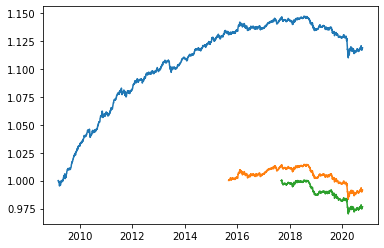

In [3]:
%%time
settings = [
            ('2009-01-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio'), 
            ('2015-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio'),
            ('2017-09-01', 0.1, 0, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'diversification_ratio')
           ]

result = {} 

for i, config in enumerate(settings):
    print(config)
    result[i] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            lower_bound=config[2],
                                            drop_strategy=config[3],
                                            target=config[4])

In [9]:
print(np.maximum(result[0]['weights'] - 0.02, 0), np.minimum(result[0]['weights'] + 0.02, 0.1))

[0.01660386 0.08       0.08       0.         0.0375598  0.08
 0.05253484 0.0152118  0.08       0.08       0.00741106 0.
 0.02740593 0.0038014  0.0088387  0.08       0.02781306] [0.05660386 0.1        0.1        0.024351   0.0775598  0.1
 0.09253484 0.0552118  0.1        0.1        0.04741106 0.03846854
 0.06740593 0.0438014  0.0488387  0.1        0.06781306]


In [12]:
bound_1 = [(lower,upper) for lower, upper in zip(np.maximum(result[0]['weights'] - 0.02, 0), 
                                                 np.minimum(result[0]['weights'] + 0.02, 0.1))]
bound_2 = [(lower,upper) for lower, upper in zip(np.maximum(result[1]['weights'] - 0.02, 0), 
                                                 np.minimum(result[1]['weights'] + 0.02, 0.1))]
bound_3 = [(lower,upper) for lower, upper in zip(np.maximum(result[2]['weights'] - 0.02, 0), 
                                                 np.minimum(result[2]['weights'] + 0.02, 0.1))]

('2009-01-01', [(0.016603860885799276, 0.05660386088579927), (0.08, 0.1), (0.08, 0.1), (0.0, 0.024351000505150103), (0.03755980368194528, 0.07755980368194529), (0.08, 0.1), (0.052534844853819845, 0.09253484485381985), (0.01521179732406534, 0.05521179732406534), (0.08, 0.1), (0.07999999999999993, 0.1), (0.007411061224468399, 0.0474110612244684), (0.0, 0.03846853982691304), (0.02740592973900378, 0.06740592973900378), (0.0038014040046234904, 0.04380140400462349), (0.008838695518315839, 0.048838695518315836), (0.0799999999999999, 0.1), (0.027813062435895156, 0.06781306243589516)], ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio')
('2015-09-01', [(0.00795644104231015, 0.04795644104231015), (0.0639701048311445, 0.1), (0.08, 0.1), (0.0, 0.020000000000000004), (0.025589056351814524, 0.06558905635181453), (0.07999999999999975, 0.1), (0.06351184371535232, 0.1), (0.009399036517612203, 0.0493990365176122), (0.0799999999999991, 0.1), (0.0799999999999996, 0.1), (0.014548073

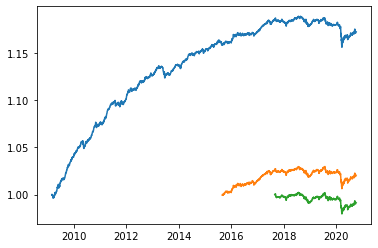

In [15]:
settings_ = [
            ('2009-01-01', bound_1, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio'), 
            ('2015-09-01', bound_2, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio'),
            ('2017-09-01', bound_3, ['equity_trend', 'fx_value', 'commodity_volatility_carry'], 'sharpe_ratio')
           ]

result_ = {} 

for i, config in enumerate(settings_):
    print(config)
    result_[i] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            input_bound=config[1],
                                            drop_strategy=config[2],
                                            target=config[3])

In [18]:
# config = 0

In [19]:
# from PortfolioPerformance import * 
# return_compoent = result[config]['df_return'].set_index('Date').fillna(0)
# weights = result[config]['weights'] 

In [20]:
# start_date = return_compoent.index[0]
# month_end_list = [start_date] + list(pd.date_range(start_date, '2020-10-07', freq='BM'))

In [21]:
# strategy_list = list(return_compoent.columns[1:])
# d = {strategy: weights[i] for i, strategy in enumerate(strategy_list)}
# weight_component = pd.DataFrame(d, index=month_end_list)


In [22]:
# weight_component.columns

In [23]:
# return_compoent[weight_component.columns].columns

In [24]:
# %%time
# df_rebalanced_port = Get_Portfolio_Index(return_compoent[weight_component.columns], weight_component)

In [25]:
# plt.plot(df_rebalanced_port['portfolio_index']/1000)

In [26]:
# weight_component.tail()

In [27]:
# weight_component.head()

In [28]:
# return_compoent.tail()